In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path) 
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

Shape of the data is 20640 rows and 10 features

In [3]:
ca_housing = load_housing_data()
ca_housing.head()
ca_housing.shape

(20640, 10)

total_bedrooms has only 20433 non-null values so there are missing values


In [4]:
ca_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
ca_housing.describe()

# we can look up the object feature
ca_housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

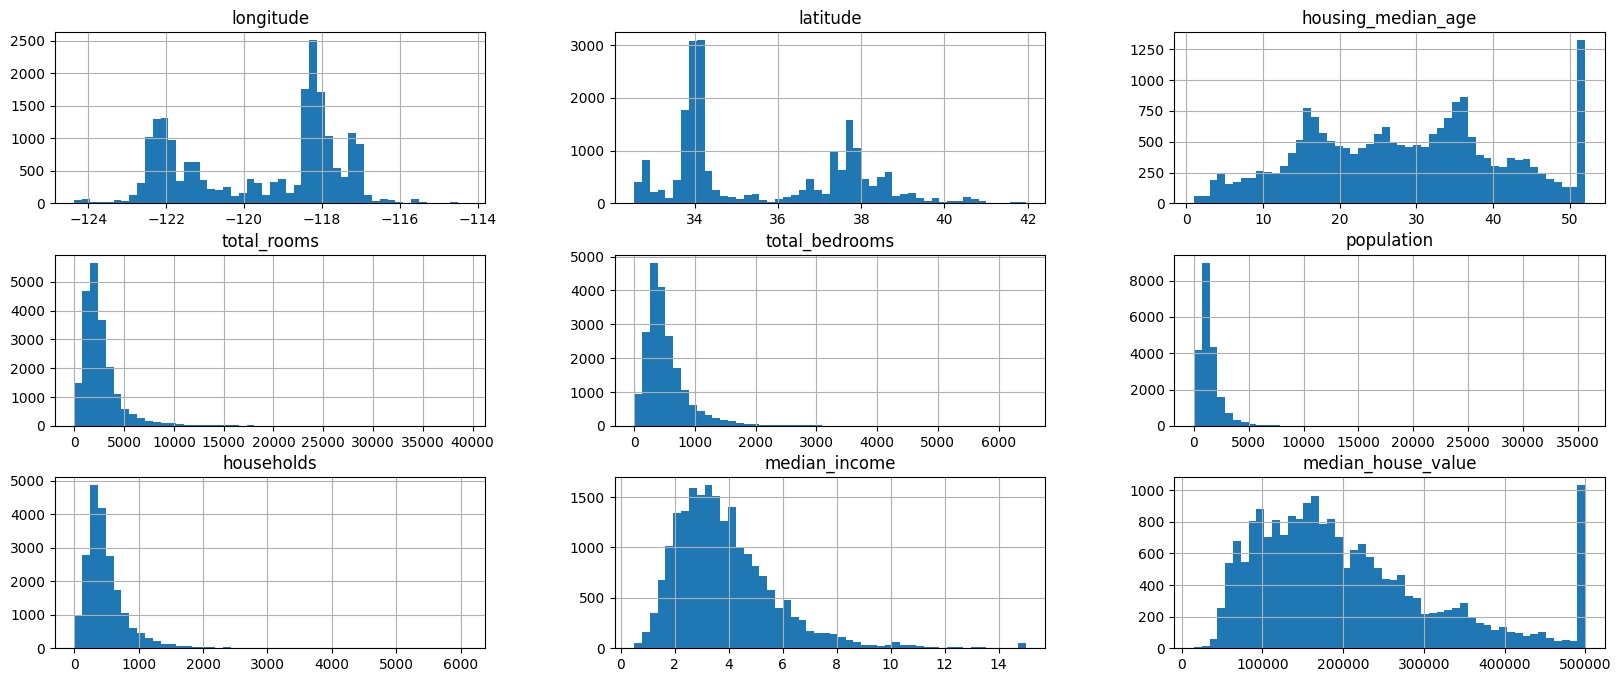

In [6]:
ca_housing.hist(bins=50, figsize=(20, 8))
plt.show()

- The median income is scaled and capped between 0.5 - 15, the number represents ten of thousands of dollars. For example 5 actually means $50,000.
- Housing median age and median house value are also capped. median_house_value is the target variable, so this may pouse a significant problem.
- Features have differents scales.
- Some features are right-skewed, meaning they extend much farther to the right of the median than to the left. This makes slightly more dificult for regression ml algorithms to detect patterns.

### Before continuing, we will create a test set and set it aside and hold it out for later evaluation

### **Data Snooping**


In [7]:
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42)
    # shaffle() method makes changes is the original data 
    shuffled_indices = np.random.permutation(len(data)) #permutation() method returns a new "shuffle" data leaving the original data untouched.
    test_set_size = int(len(data) * test_ratio) # i.e. 100 * 0.2 = test size is 20
    test_indices = shuffled_indices[:test_set_size] # we're printing 20 first rows
    train_indices = shuffled_indices[test_set_size:] # we're iterating the last 80 rows
    return data.iloc[train_indices], data.iloc[test_indices] 

In [8]:
train_set, test_set = shuffle_and_split_data(ca_housing, 0.2)
print(f"train size: {len(train_set)}\ntest size: {len(test_set)}")

train size: 16512
test size: 4128


We have considered `median income` as an important feature for the stratified split

In [9]:

ca_housing['income_cat'] = pd.cut(
    ca_housing['median_income'],
    bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
    labels=[1,2,3,4,5]
)

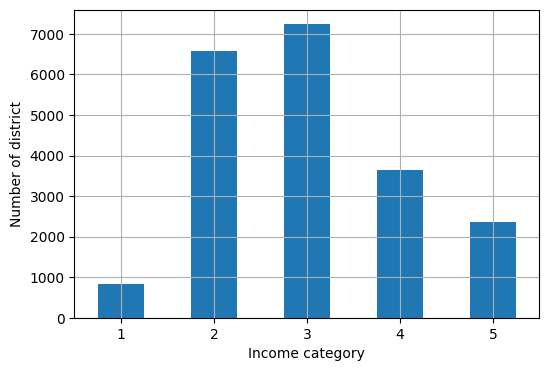

In [10]:
ca_housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True,figsize=(6, 4))
plt.xlabel("Income category")
plt.ylabel("Number of district")
plt.show()

We will generate 10 different stratiffied splits to use in cross-validation later

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_idx, test_idx in splitter.split(X=ca_housing, y=ca_housing['income_cat']):# .split() works with the indices
    strat_train_set_n = ca_housing.iloc[train_idx] # that's why we use iloc here
    strat_test_set_n = ca_housing.iloc[test_idx]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [13]:
strat_train_set, strat_test_set = strat_splits[0]
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN,2
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND,2
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN,4
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY,4


If we're going to use a single split, use `train_test_split` with the `stratify` argument

In [14]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_train_set = train_test_split(ca_housing, test_size=0.2, stratify=ca_housing['income_cat'], random_state=42)


In [15]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN,2
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND,2
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN,4
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY,4


In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17356\4166485955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop('income_cat', axis=1, inplace=True)


Make a copy before experiment with the data.

In [17]:
housing = strat_train_set.copy()

### **Explore and visualize to gain Insights**

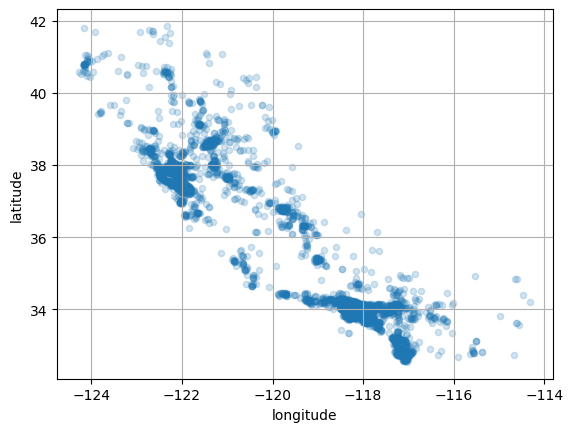

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.show()

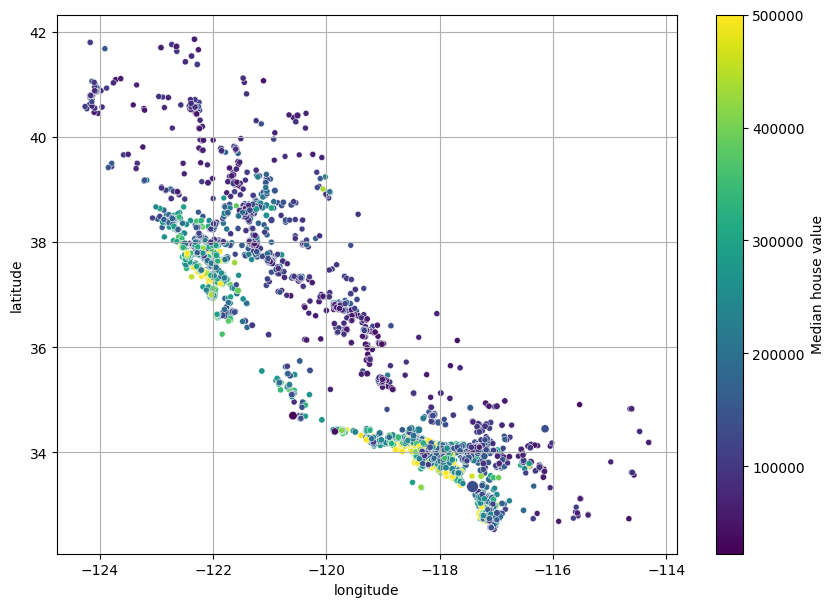

In [19]:
import seaborn as sns
plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    data=housing, x='longitude', y='latitude', 
    size=housing['population']/100, hue='median_house_value',
    palette='viridis'
)           
norm = plt.Normalize(housing['median_house_value'].min(), housing['median_house_value'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax, label='Median house value')
plt.grid()
plt.show()

Looking for correlations between independent variables (also called Pearson's r)

<Axes: >

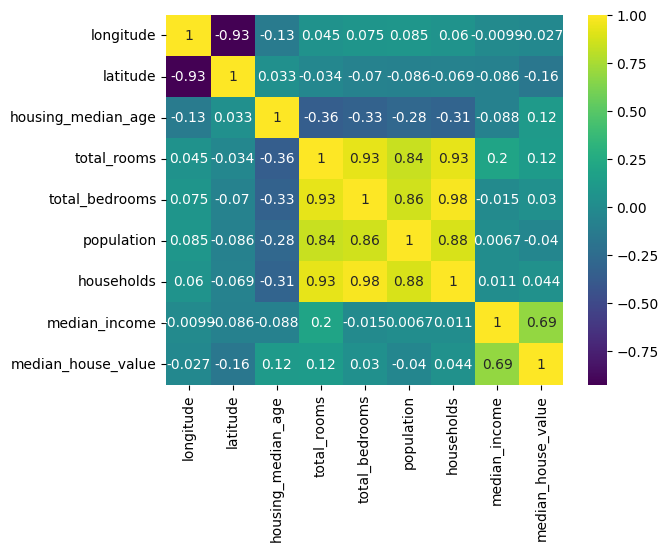

In [20]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix
sns.heatmap(corr_matrix, cmap='viridis', annot=True)

Correlated variables with the target variable `median_house_value` (positive and negative way)

In [21]:
corr_matrix['median_house_value'].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687091
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
longitude            -0.026768
population           -0.040286
latitude             -0.162087
Name: median_house_value, dtype: float64

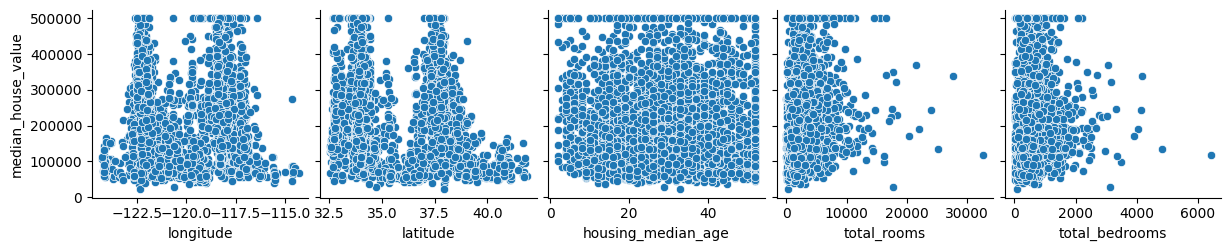

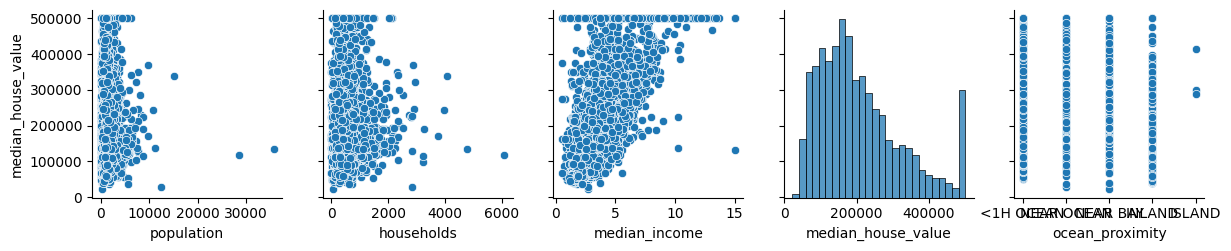

In [22]:
def plot_relation(data, target):
    for i in range(0, len(data.columns), 5):
        sns.pairplot(
            data=data,
            x_vars=data.columns[i:i+5],
            y_vars=[target]
        )

plot_relation(housing, 'median_house_value')

<Axes: xlabel='median_income', ylabel='median_house_value'>

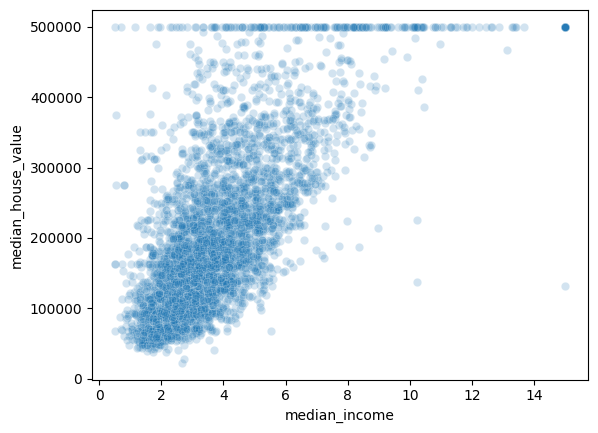

In [23]:
sns.scatterplot(data=housing, x='median_income', y='median_house_value', alpha=0.2)

### **Experiment with attribute combinations**

In [24]:
housing['room_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [27]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687091
room_per_house        0.198322
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
people_per_house     -0.025974
longitude            -0.026768
population           -0.040286
latitude             -0.162087
bedrooms_ratio       -0.254506
Name: median_house_value, dtype: float64

### **Prepare the data for Machine learning algorithms**

In [28]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### **Cleaning the data for ML**

You have three options to fix this:
- Get rid of the districts (rows)
- Get rid of whole attribute (colum)
- Imputation: set missing values to some value (zero, mean, median,etc)

In [ ]:
# option 1
housing.dropna(subset=['total_bedrooms'], inplace=True)
# option 2
housing.drop('total_bedrooms', axis=1)
# option 3
median = housing['total_bedrooms'].median()
housing.fillna(median, inplace=True)

A more efficient way to do it is using `SimpleImputer` from Scikit-Learn. It stores the median value of each feature

In [29]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
# the median can only be computed on numerical attributes
housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
imputer.statistics_

array([-118.46  ,   34.23  ,   29.    , 2137.5   ,  438.    , 1163.    ,
        412.5   ,    3.5269])

Now we have the imputed data we can use this to transform the training set by replacing missing values with learned medians.

There are also more powerfull imputers in the sklearn packages (both for numercial data only)
- `KNNImputer` : replaces with the k-neighbors values for that feature
- `IterativeImputer` : trains a regression model per feature with all the available data

In [31]:
X = imputer.transform(housing_num)


### **Handling categorical attributes**

In [32]:
housing_cat = housing[['ocean_proximity']]
housing_cat

,ocean_proximity
3905,<1H OCEAN
16821,<1H OCEAN
2900,NEAR OCEAN
7193,NEAR OCEAN
13928,NEAR BAY
...,...
12369,NEAR OCEAN
8707,INLAND
16634,<1H OCEAN
9779,NEAR BAY


Most machine learning algorithms prefer to work with numbers, so we're going to convert these categories into numberical values.
We can use `OrdinalEncoder`

In [33]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encouder = OrdinalEncoder()
house_cat_encoded = ordinal_encouder.fit_transform(housing_cat)
house_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [0.],
       [3.],
       [4.]])

In [36]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
house_cat_ohe = ohe.fit_transform(housing_cat)
print(house_cat_ohe)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4128 stored elements and shape (4128, 5)>
  Coords	Values
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 4)	1.0
  (4, 3)	1.0
  (5, 0)	1.0
  (6, 3)	1.0
  (7, 0)	1.0
  (8, 4)	1.0
  (9, 4)	1.0
  (10, 0)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 3)	1.0
  (15, 4)	1.0
  (16, 1)	1.0
  (17, 1)	1.0
  (18, 0)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (4103, 4)	1.0
  (4104, 1)	1.0
  (4105, 0)	1.0
  (4106, 0)	1.0
  (4107, 3)	1.0
  (4108, 4)	1.0
  (4109, 1)	1.0
  (4110, 0)	1.0
  (4111, 4)	1.0
  (4112, 1)	1.0
  (4113, 0)	1.0
  (4114, 0)	1.0
  (4115, 0)	1.0
  (4116, 1)	1.0
  (4117, 0)	1.0
  (4118, 0)	1.0
  (4119, 1)	1.0
  (4120, 4)	1.0
  (4121, 1)	1.0
  (4122, 1)	1.0
  (4123, 4)	1.0
  (4124, 1)	1.0
  (4125, 0)	1.0
  (4126, 3)	1.0
  (4127, 4)	1.0


The output of OHE is a scipy sparse matrix instead of numpy array, but you can convert it to a numpy array by calling the `toarray()` method

In [39]:
#ohe.categories_
#pd.get_dummies(housing_cat) # prefer never to use for converting